# Generative data

The goal here is to simulate data under a generative model and then to assess the ability of our probabilistic models to estimate the correct parameter values in their posteriors.

We fit a hierarchical linear model in pymc3 as in:

- [https://twiecki.io/blog/2014/03/17/bayesian-glms-3/](https://twiecki.io/blog/2014/03/17/bayesian-glms-3/)  
- [https://discourse.pymc.io/t/help-with-censored-regression/4617/21](https://discourse.pymc.io/t/help-with-censored-regression/4617/21)  
- [https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html](https://docs.pymc.io/notebooks/Diagnosing_biased_Inference_with_Divergences.html)

In [1]:
# conda install toytree pymc3 -c conda-forge

In [2]:
import itertools
import pandas as pd
import numpy as np
import toytree
import toyplot
import arviz as az
import pymc3 as pm
from pymc3.distributions.dist_math import normal_lccdf, normal_lcdf

In [3]:
toyplot.config.autoformat = "png"

### The phylogeny
We will simulate data on a phylogeny with four clades that have different rates of evolution of reproductive incompatibility, colored below. 

In [4]:
# generate a balanced 128-tip tree with root 30Mya and randomly slide edge lengths
TREE = toytree.rtree.baltree(ntips=128, treeheight=30e6)
TREE = TREE.mod.node_slider(prop=0.7)

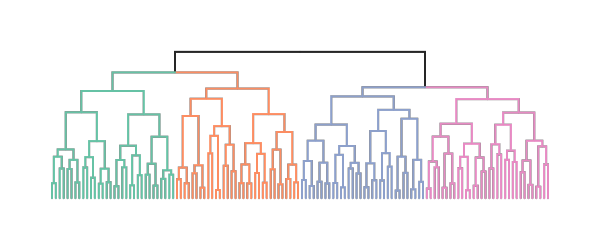

In [5]:
# draw and color the four major clades
TREE.draw(
    layout='d', 
    width=600,
    tip_labels=False,
    edge_colors=TREE.get_edge_values_mapped({
        248: toytree.colors[0],
        249: toytree.colors[1],
        250: toytree.colors[2],
        251: toytree.colors[3],
    }),
);

### Linear model of RI with time

We will model incompatibility as something that accumulates linearly with time since divergence, with the rate parameter varying among the four clades. The question is: "does genetic distance predict the level of genetic incompatibility between species?". To implement a hierarchical model we are additionally asking: "Does information about which clade the species is from improve estimation?"


$$ Y_{ij} = \alpha + (\beta + \psi_i + \psi_j) X_{ij} + \sigma $$

$ \alpha$ = intercept    
$ \beta$ = base RI velocity  
$ X_{ij}$ = genetic divergence  
$ Y_{ij}$  = Reproductive incompatibility  
$ \psi$ = species RI velocity  
$ \sigma$ = error

In [6]:
# True param values
𝛼_mean = 0.05
𝛼_std = 0.005
𝛽_mean = 1.5
𝛽_std = 0.05
𝜓_mean = 0.0
𝜓_std = 0.33
𝜎_std = 0.1

In [7]:
# 4 different clade effects on rate of RI (used for partial-pooling data)
𝜓_0_mean = 1.0
𝜓_0_std = 0.2
𝜓_1_mean = 0.5
𝜓_1_std = 0.1
𝜓_2_mean = -0.5
𝜓_2_std = 0.05
𝜓_3_mean = -1.0
𝜓_3_std = 0.1

## Generate species-level data

Generate a true RI velocity for each species under all three models.

In [8]:
SPECIES_DATA = pd.DataFrame({
    "𝛽": np.random.normal(𝛽_mean, 𝛽_std, 128),
    "𝜓": np.random.normal(𝜓_mean, 𝜓_std, 128),
    "𝜓_x": np.concatenate([
        np.random.normal(𝜓_0_mean, 𝜓_0_std, 32),
        np.random.normal(𝜓_1_mean, 𝜓_1_std, 32),
        np.random.normal(𝜓_2_mean, 𝜓_2_std, 32),
        np.random.normal(𝜓_3_mean, 𝜓_3_std, 32),
    ]),
    "gidx": np.concatenate([
        np.repeat(0, 32),
        np.repeat(1, 32),
        np.repeat(2, 32),
        np.repeat(3, 32),
    ]),
})

# species RI velocity is the base velocity times species specific 
SPECIES_DATA["velo"] = SPECIES_DATA["𝛽"] + SPECIES_DATA["𝜓"]
SPECIES_DATA["velo_x"] = SPECIES_DATA["𝛽"] + SPECIES_DATA["𝜓_x"]
SPECIES_DATA.head()

,𝛽,𝜓,𝜓_x,gidx,velo,velo_x
0,1.558787,0.397524,1.095140,0,1.956312,2.653928
1,1.537490,0.300842,0.772802,0,1.838332,2.310292
2,1.559052,0.000562,0.959035,0,1.559614,2.518087
3,1.425644,-0.340009,1.170201,0,1.085636,2.595846
4,1.500275,-0.116074,1.038287,0,1.384201,2.538562


## Generate crossing data

In [10]:
NSAMPLES = 2000
RNG = np.random.default_rng(123)

In [11]:
# sample random cross pairs
crosses = RNG.choice(TREE.get_tip_labels(), size=(NSAMPLES, 2))

# translate names to indices
name2nidx = TREE.get_feature_dict("name", "idx")

# randomly choose tip idx numbers maternal and paternal
data = pd.DataFrame({
    "sp0": crosses[:, 0],
    "sp1": crosses[:, 1],
    "sidx0": [name2nidx[i] for i in crosses[:, 0]],
    "sidx1": [name2nidx[i] for i in crosses[:, 1]],
    "geo_overlap": 0,
    "genetic_dist": 0.,
})

In [9]:
def get_dist(tree, idx0, idx1):
    "returns the genetic distance between two nodes on a tree"
    dist = tree.treenode.get_distance(
        tree.idx_dict[idx0], 
        tree.idx_dict[idx1],
    )
    return dist

In [12]:
# calc genetic distances and normalize to range(0, 1)
data['genetic_dist'] = [get_dist(TREE, *data.iloc[idx, [2, 3]]) / 2 for idx in data.index]
data['genetic_dist'] += data['genetic_dist'].min()
data['genetic_dist'] /= data['genetic_dist'].max()

In [13]:
intercept = RNG.normal(𝛼_mean, 𝛼_std, data.shape[0])
error = RNG.normal(0.0, 𝜎_std, data.shape[0])

In [14]:
data['RI_pooled'] = data.genetic_dist * SPECIES_DATA.loc[data.sidx0, "𝛽"].values
data['RI_pooled'] += intercept + error

In [15]:
data['RI_unpooled'] = data.genetic_dist * SPECIES_DATA.loc[data.sidx0, "velo"].values
data['RI_unpooled'] += intercept + error

In [16]:
data['RI_groups'] = data.genetic_dist * SPECIES_DATA.loc[data.sidx0, "velo_x"].values
data['RI_groups'] += intercept + error

In [17]:
# censor values in range 0-1
data.loc[data['RI_pooled'] < 0, 'RI_pooled'] = 0
data.loc[data['RI_pooled'] > 1, 'RI_pooled'] = 1
data.loc[data['RI_unpooled'] < 0, 'RI_unpooled'] = 0
data.loc[data['RI_unpooled'] > 1, 'RI_unpooled'] = 1
data.loc[data['RI_groups'] < 0, 'RI_groups'] = 0
data.loc[data['RI_groups'] > 1, 'RI_groups'] = 1

In [18]:
data.head()

,sp0,sp1,sidx0,sidx1,geo_overlap,genetic_dist,RI_pooled,RI_unpooled,RI_groups
0,r1,r87,1,87,0,1.000000,1.0,1.0,1.000000
1,r75,r6,75,6,0,1.000000,1.0,1.0,1.000000
2,r116,r28,116,28,0,1.000000,1.0,1.0,0.587358
3,r32,r23,32,23,0,0.860284,1.0,1.0,1.000000
4,r42,r22,42,22,0,0.860284,1.0,1.0,1.000000


In [19]:
data.describe()

,sidx0,sidx1,geo_overlap,genetic_dist,RI_pooled,RI_unpooled,RI_groups
count,2000.000000,2000.000000,2000.0,2000.000000,2000.000000,2000.000000,2000.000000
mean,63.436000,62.898500,0.0,0.838988,0.957824,0.938809,0.819990
std,37.157331,36.561025,0.0,0.206629,0.148466,0.166214,0.251282
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,31.000000,31.750000,0.0,0.748996,1.000000,1.000000,0.639803
50%,64.000000,62.000000,0.0,0.860284,1.000000,1.000000,1.000000
75%,96.000000,94.000000,0.0,1.000000,1.000000,1.000000,1.000000
max,127.000000,127.000000,0.0,1.000000,1.000000,1.000000,1.000000


## Visualize crossing data

Drop data points where the maternal and paternal organisms are the same one, since we randomly selected them. Then log transform the divergence time estimates to make for prettier plotting and simpler model fitting. 

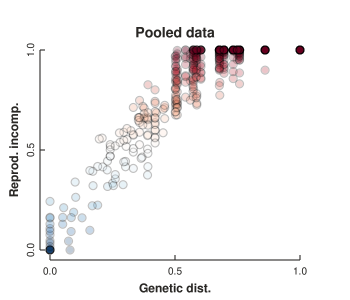

In [20]:
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(
    label="Pooled data",
    xlabel="Genetic dist.",
    ylabel="Reprod. incomp.",
)

# points are jittered on x-axis for visibility
axes.scatterplot(
    data.genetic_dist,
    data.RI_pooled,
    size=8,
    opacity=0.25,
    color=data.loc[:, 'RI_pooled'].values,
    mstyle={"stroke": "black"},
);
axes.x.ticks.show = True
axes.y.ticks.show = True

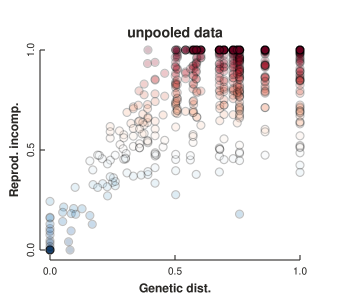

In [21]:
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(
    label="unpooled data",
    xlabel="Genetic dist.",
    ylabel="Reprod. incomp.",
)

# points are jittered on x-axis for visibility
axes.scatterplot(
    data.genetic_dist,
    data.RI_unpooled,
    size=8,
    opacity=0.25,
    color=data.loc[:, 'RI_unpooled'].values,
    mstyle={"stroke": "black"},
);
axes.x.ticks.show = True
axes.y.ticks.show = True

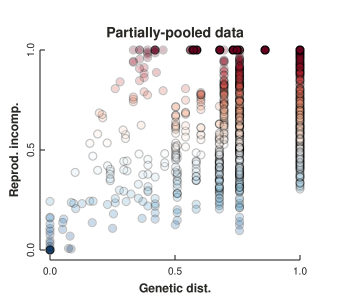

In [22]:
canvas = toyplot.Canvas(width=350, height=300)
axes = canvas.cartesian(
    label="Partially-pooled data",
    xlabel="Genetic dist.",
    ylabel="Reprod. incomp.",
)

# points are jittered on x-axis for visibility
axes.scatterplot(
    data.genetic_dist,
    data.RI_groups,
    size=8,
    opacity=0.25,
    color=data.loc[:, 'RI_groups'].values,
    mstyle={"stroke": "black"},
);
axes.x.ticks.show = True
axes.y.ticks.show = True

### Pairwise RI heatmap of sparse crossing data

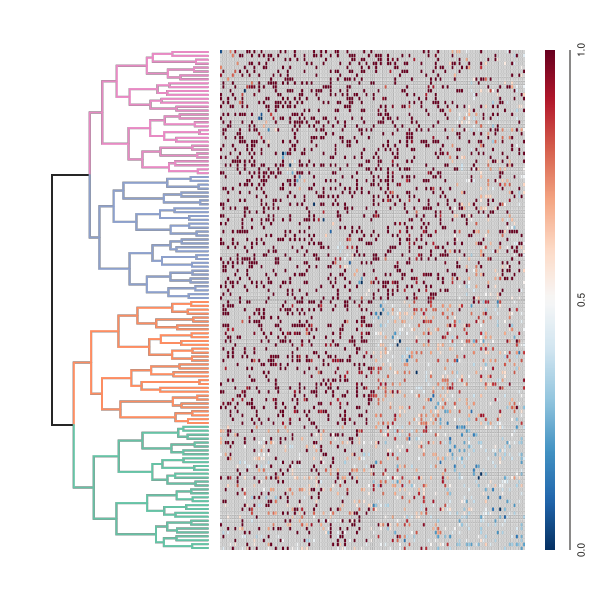

In [23]:
# get canvas size
canvas = toyplot.Canvas(width=600, height=600);

# colormap for values between 0-1
cmap = toyplot.color.LinearMap(domain_min=0, domain_max=1.0)

# add tree to canvas
ax0 = canvas.cartesian(bounds=(50, 210, 50, 550), show=False)
TREE.draw(
    axes=ax0, 
    layout='r', 
    tip_labels=False,
    edge_colors=TREE.get_edge_values_mapped({
        248: toytree.colors[0],
        249: toytree.colors[1],
        250: toytree.colors[2],
        251: toytree.colors[3],
    }),
);

# add heatmap to canvas
ax1 = canvas.table(rows=128, columns=128, bounds=(220, 525, 50, 550), margin=20)
for ridx in range(128):
    for cidx in range(128):
        
        # get RI for this cell
        d0 = data[(data.sidx0 == ridx) & (data.sidx1 == cidx)]
        d1 = data[(data.sidx1 == ridx) & (data.sidx0 == cidx)]
        
        # color cells if matxpat or patxmat cross in dataset
        if d0.size:
            col = cmap.color(d0.RI_groups.iloc[0])
            ax1.cells.cell[ridx, cidx].style = {
                "fill": col, "stroke": "none"
            }
        elif d1.size:
            col = cmap.color(d1.RI_groups.iloc[0])
            ax1.cells.cell[ridx, cidx].style = {
                "fill": col, "stroke": "none"
            }
            
        # if not in dataset then color it grey
        else:
            ax1.cells.cell[ridx, cidx].style = {
                "fill": "lightgrey", "stroke": "none"
            }

# style spacing between grid cells            
ax1.body.gaps.columns[...] = 0.5
ax1.body.gaps.rows[...] = 0.5

# add a colorbar to canvas
numberline = canvas.numberline(550, 550, 550, 50)
numberline.colormap(cmap, style={"stroke-width":5})

### (HYPOTHETICAL) heatmap of imputed cross probabilities given final parameters

After applying our hierarchical linear regression to estimate clade-specific rates of RI accumulation we can then estimate the RI between all species pairs based on the clade they belong to and the genetic distance between them. The final heatmap would look something like this, and we could color the tree by these values too.

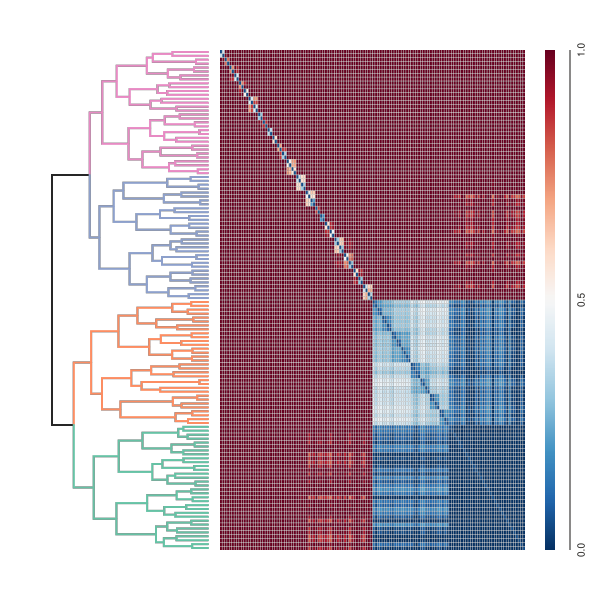

In [24]:
# get canvas size
canvas = toyplot.Canvas(width=600, height=600);

# colormap for values between 0-1
cmap = toyplot.color.LinearMap(domain_min=0, domain_max=1.0)

# add tree to canvas
ax0 = canvas.cartesian(bounds=(50, 210, 50, 550), show=False)
TREE.draw(
    axes=ax0, 
    layout='r', 
    tip_labels=False,
    edge_colors=TREE.get_edge_values_mapped({
        248: toytree.colors[0],
        249: toytree.colors[1],
        250: toytree.colors[2],
        251: toytree.colors[3],
    }),
);

maxdist = max([
    get_dist(TREE, i, j) / 2. for (i, j) in itertools.product(range(128), range(128))
])

# add heatmap
ax1 = canvas.table(rows=128, columns=128, bounds=(220, 525, 50, 550), margin=20)
for t0 in TREE.get_tip_labels():
    for t1 in TREE.get_tip_labels():

        # generate error
        ridx = name2nidx[t0]
        cidx = name2nidx[t1]
        dist = (get_dist(TREE, ridx, cidx) / 2.) / maxdist

        # get RI
        spp_effects = SPECIES_DATA.at[ridx, "𝜓_x"] + SPECIES_DATA.at[cidx, "𝜓_x"] 
        ri = 𝛼_mean + (𝛽_mean + spp_effects) * dist

        # normalize -- cannot be >1 or <0
        col = cmap.color(ri)
        ax1.cells.cell[ridx, cidx].style = {
            "fill": col, "stroke": "none"
        }

# dividers
ax1.body.gaps.columns[...] = 0.5
ax1.body.gaps.rows[...] = 0.5

# add a colorbar
numberline = canvas.numberline(550, 550, 550, 50)
numberline.colormap(cmap, style={"stroke-width":5})

# Bayesian model fitting

### Function to plotting posterior traces

In [26]:
def toytrace(trace, var_names, titles):
    """
    Plot posterior trace with toyplot
    """
    nvars = len(var_names)
    
    # setup canvase
    canvas = toyplot.Canvas(width=500, height=200 * nvars)
    
    # store axes
    axes = []
    
    # iter over params
    for pidx, param in enumerate(var_names):
        
        # get param posterior
        posterior = trace.get_values(param)
        
        # setup axes 
        ax = canvas.cartesian(grid=(nvars, 1, pidx))
        ax.y.show = False
        ax.x.spine.style = {"stroke-width": 1.5}
        ax.x.ticks.labels.style = {"font-size": "12px"}
        ax.x.ticks.show = True
        ax.x.label.text = f"param='{titles[pidx]}'"        
        
        # iterate over shape of param
        for idx in range(posterior.shape[1]):
            mags, bins = np.histogram(posterior[:, idx], bins=100)
            ax.plot(bins[1:], mags, stroke_width=2, opacity=0.6)
        axes.append(ax)
    return canvas, axes

<h2><i>Setup <span style="color:red">pooled</span> model</i></h2>

Treat all species the same, and estimate a single RI velocity.

$$ \text{RI}_{i,j} = \alpha + (\beta + \psi) X_{i,j} + \sigma $$

In [33]:
def censored_pooled_regression(x, y, **kwargs):
    
    # data pre-processing
    lower_censored = y[y <= 0].index
    _x_lc = x[lower_censored].values
    _y_lc = y[lower_censored].values

    upper_censored = y[y >= 1].index
    _x_uc = x[upper_censored].values
    _y_uc = y[upper_censored].values

    uncensored = (y > 0) & (y < 1)
    _x = x[uncensored].values
    _y = y[uncensored].values
    
    # define model
    with pm.Model() as model:  

        # parameters and error
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝜎 = pm.HalfNormal('𝜎', 5.0, shape=1)

        # linear model prediction
        ri = 𝛼 + 𝛽 * _x

        # data likelihood (normal distributed errors)
        y = pm.Normal("y", mu=ri, sigma=𝜎, observed=_y)

        # density of censored data
        if sum(lower_censored):
            lcensored = pm.Potential(
                "lower_censored", 
                normal_lcdf(𝛼 + 𝛽 * _x_lc, 𝜎, _y_lc),
            )
        if sum(upper_censored):
            ucensored = pm.Potential(
                "upper_censored",
                normal_lccdf(𝛼 + 𝛽 * _x_uc, 𝜎, _y_uc),
            )

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]
    
        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

<h2><i>Setup <span style="color:red">unpooled</span> model</i></h2>

Fit a different RI velocity to every species.

$$ \text{RI}_{i,j} = \alpha + (\beta + \psi_i + \psi_j) X_{i,j} + \epsilon $$

In [34]:
def censored_unpooled_noncentered_regression(x, y, idx0, idx1, **kwargs):
    
    # data pre-processing
    lower_censored = y[y <= 0].index
    _x_lc = x[lower_censored].values
    _y_lc = y[lower_censored].values

    upper_censored = y[y >= 1].index
    _x_uc = x[upper_censored].values
    _y_uc = y[upper_censored].values

    uncensored = (y > 0) & (y < 1)
    _x = x[uncensored].values
    _y = y[uncensored].values
    
    # define model
    with pm.Model() as model:
        
        # censored indexers
        sidx0 = pm.Data("spp_idx0", idx0.values[uncensored])
        sidx1 = pm.Data("spp_idx1", idx1.values[uncensored])
        sidx0_u = pm.Data("sidx0_u", idx0.values[upper_censored])
        sidx1_u = pm.Data("sidx1_u", idx1.values[upper_censored])
        sidx0_l = pm.Data("sidx0_l", idx0.values[lower_censored])
        sidx1_l = pm.Data("sidx1_l", idx1.values[lower_censored])

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=1)
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=1)
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=128)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean + 𝜓_std * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        𝜎 = pm.HalfNormal('𝜎', 5., shape=1)
        
        # linear model prediction
        ri = 𝛼 + (𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * _x

        # data likelihood (normal distributed errors)
        y = pm.Normal("y", mu=ri, sigma=𝜎, observed=_y)

        # density of censored data
        if sum(lower_censored):
            lcensored = pm.Potential(
                "lower_censored", 
                normal_lcdf(𝛼 + (𝛽 + 𝜓[sidx0_l] + 𝜓[sidx1_l]) * _x_lc, 𝜎, _y_lc),
            )
        
        if sum(upper_censored):
            ucensored = pm.Potential(
                "upper_censored",
                normal_lccdf(𝛼 + (𝛽 + 𝜓[sidx0_u] + 𝜓[sidx1_u]) * _x_uc, 𝜎, _y_uc),
            )

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

<h2><i>Setup <span style="color:red">partially-pooled</span> model</i></h2>

Fit a different RI velocity to every species, but drawn from a hyperprior distribution for the clade/group they belong to.


$$ \psi_g \sim \mathcal{N}(\mu_g, \sigma^2_g) $$

$$ \text{RI}_{i,j} = \alpha + (\beta + \psi_{g,i} + \psi_{g,j})X_{i,j} + \sigma $$

In [35]:
def censored_partpooled_noncentered_regression(x, y, idx0, idx1, gidx, **kwargs):
    
    # data pre-processing
    lower_censored = y[y <= 0].index
    _x_lc = x[lower_censored].values
    _y_lc = y[lower_censored].values

    upper_censored = y[y >= 1].index
    _x_uc = x[upper_censored].values
    _y_uc = y[upper_censored].values

    uncensored = (y > 0) & (y < 1)
    _x = x[uncensored].values
    _y = y[uncensored].values
    
    # define model
    with pm.Model() as model:
        
        # censored indexers
        sidx0 = pm.Data("spp_idx0", idx0.values[uncensored])
        sidx1 = pm.Data("spp_idx1", idx1.values[uncensored])
        sidx0_u = pm.Data("sidx0_u", idx0.values[upper_censored])
        sidx1_u = pm.Data("sidx1_u", idx1.values[upper_censored])
        sidx0_l = pm.Data("sidx0_l", idx0.values[lower_censored])
        sidx1_l = pm.Data("sidx1_l", idx1.values[lower_censored])
        gidx = pm.Data("gidx", gidx)

        # parameters and error
        𝜓_mean = pm.Normal('𝜓_mean', mu=0., sigma=5., shape=4)
        𝜓_std = pm.HalfNormal('𝜓_std', 5., shape=4)
        𝜓_offset = pm.Normal('𝜓_offset', mu=0, sigma=1., shape=128)
        𝜓 = pm.Deterministic('𝜓', 𝜓_mean[gidx] + 𝜓_std[gidx] * 𝜓_offset)
        𝛽 = pm.Normal('𝛽', mu=0., sigma=10., shape=1)
        𝛼 = pm.Normal('𝛼', mu=0., sigma=10., shape=1)
        𝜎 = pm.HalfNormal('𝜎', 5., shape=1)
        
        # linear model prediction
        ri = 𝛼 + (𝛽 + 𝜓[sidx0] + 𝜓[sidx1]) * _x

        # data likelihood (normal distributed errors)
        y = pm.Normal("y", mu=ri, sigma=𝜎, observed=_y)

        # density of censored data
        if sum(lower_censored):
            lcensored = pm.Potential(
                "lower_censored", 
                normal_lcdf(𝛼 + (𝛽 + 𝜓[sidx0_l] + 𝜓[sidx1_l]) * _x_lc, 𝜎, _y_lc),
            )
        
        if sum(upper_censored):
            ucensored = pm.Potential(
                "upper_censored",
                normal_lccdf(𝛼 + (𝛽 + 𝜓[sidx0_u] + 𝜓[sidx1_u]) * _x_uc, 𝜎, _y_uc),
            )

        # sample posterior, skip burnin
        trace = pm.sample(**kwargs)[1000:]

        # show summary table
        stats = pm.summary(trace)
        
    # organize results
    result_dict = {
        'model': model, 
        'trace': trace,
        'stats': stats,
    }
    return result_dict

### MCMC Sample Parameters

In [36]:
# MCMC sampler kwargs
sample_kwargs = dict(
    tune=2000,
    draws=4000,
    target_accept=0.90,
    return_inferencedata=False,
    progressbar=True,
)

### Fit models to data generated under the pooled model

In [ ]:
# model input
model_args = [
    data.genetic_dist,
    data.RI_pooled,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

# run models
a = censored_pooled_regression(*model_args[:2], **sample_kwargs)
b = censored_unpooled_noncentered_regression(*model_args[:4], **sample_kwargs)
c = censored_partpooled_noncentered_regression(*model_args, **sample_kwargs)

# store results
res_pooled = {
    'pooled': a,
    'unpooled': b,
    'partpooled': c,
}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, 𝛽, 𝛼]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 84 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, 𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


### Fit models to data generated under the unpooled model

In [ ]:
# model input
model_args = [
    data.genetic_dist,
    data.RI_unpooled,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

# run models
a = censored_pooled_regression(*model_args[:2], **sample_kwargs)
b = censored_unpooled_noncentered_regression(*model_args[:4], **sample_kwargs)
c = censored_partpooled_noncentered_regression(*model_args, **sample_kwargs)

# store results
res_unpooled = {
    'pooled': a,
    'unpooled': b,
    'partpooled': c,
}

### Fit models to data generated under the part-pooled model

In [ ]:
# model input
model_args = [
    data.genetic_dist,
    data.RI_groups,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
]

# run models
a = censored_pooled_regression(*model_args[:2], **sample_kwargs)
b = censored_unpooled_noncentered_regression(*model_args[:4], **sample_kwargs)
c = censored_partpooled_noncentered_regression(*model_args, **sample_kwargs)

# store results
res_partpooled = {
    'pooled': a,
    'unpooled': b,
    'partpooled': c,
}

## ------ Code below here is unfinished -------------

### TESTING

In [31]:
# run inference on pooled model
test = censored_partpooled_noncentered_regression(
    data.genetic_dist,
    data.RI_groups,
    data.sidx0,
    data.sidx1,
    SPECIES_DATA.gidx,
    **sample_kwargs,
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [𝜎, 𝛼, 𝛽, 𝜓_offset, 𝜓_std, 𝜓_mean]


Sampling 4 chains for 2_000 tune and 169 draw iterations (8_000 + 676 draws total) took 2775 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


ImportError: This function requires the python library graphviz, along with binaries. The easiest way to install all of this is by running

	conda install -c conda-forge python-graphviz

In [35]:
# run inference on pooled model
p_pooled = censored_pooled_regression(
    data.genetic_dist,
    data.RI_pooled,
    data.sidx[0],
    data.sidx[1],
    SPECIES_DATA.gidx,
    **sample_kwargs,
)

WARNING (theano.tensor.opt): Optimization Warning: The Op erfcx does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.


In [45]:
# run inference on unpooled model
p_unpooled = censored_unpooled_regression(
    data.genetic_dist,
    data.RI_pooled,
    data.sidx0,
    data.sidx1,
    **sample_kwargs,
)

The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [75]:
canvas, axes = toytrace(hierarch['trace'], ['a', 'b', 'b_spp', 'eps', 'mu_group'])
axes[0].vlines([B0], color='red')
axes[1].vlines([B1], color='red')
axes[2].vlines([0], color='red')
axes[3].vlines([ERROR], color='red');
axes[4].vlines([0, 0, 0, 0], 'red');

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="1000.0px" viewBox="0 0 500.0 1000.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td85c6c4ac0ba41c1aadede2252f42dcb"> <path d="M 58.46009155692852 149.93065187239944 L 62.41504012706055 150.0 L 66.3699886971926 149.93065187239944 L 70.32493726732461 150.0 L 74.27988583745666 149.93065187239944 L 78.23483440758869 149.93065187239944 L 82.18978297772074 149.93065187239944 L 86.14473154785276 149.8613037447989 L 90.0996801179848 149.93065187239944 L 94.05462868811682 149.93065187239944 L 98.00957725824887 149.8613037447989 L 101.9645258283809 149.72260748959778 L 105.91947439851293 149.72260748959778 L 109.87442296864498 149.65325936199721 L 113.82937153877701 149.79195561719834 L 117.78432010890904 149.65325936199721 L 121.73926867904107 149.65325936199721 L 125.69421724917311 149.09847434119277 L 129.64916581930515 149.51456310679612 L 133.60411438943717 149.2371705963939 L 137.55906295956922 148.95977808599167 L 141.51401152970126 148.26629680998613 L 145.46896009983328 148.4743411927878 L 149.42390866996533 148.19694868238557 L 153.37885724009737 147.5728155339806 L 157.3338058102294 146.25520110957004 L 161.28875438036144 146.9486823855756 L 165.24370295049346 144.52149791955617 L 169.1986515206255 134.11927877947295 L 173.15360009075755 140.7766990291262 L 177.10854866088957 140.91539528432733 L 181.0634972310216 144.0360610263523 L 185.01844580115363 142.85714285714286 L 188.9733943712857 139.32038834951456 L 192.9283429414177 134.6740638002774 L 196.88329151154974 133.5644937586685 L 200.8382400816818 126.2135922330097 L 204.7931886518138 125.38141470180304 L 208.74813722194585 129.54230235783635 L 212.70308579207784 117.89181692094311 L 216.65803436220992 110.74895977808598 L 220.61298293234194 91.8862690707351 L 224.56793150247398 109.63938973647711 L 228.52288007260603 107.55894590846046 L 232.47782864273807 86.40776699029125 L 236.43277721287006 104.64632454923716 L 240.38772578300214 50.0 L 244.34267435313416 97.91955617198334 L 248.2976229232662 112.48266296809985 L 252.25257149339825 92.30235783633842 L 256.20752006353024 111.71983356449374 L 260.1624686336623 103.60610263522884 L 264.11741720379433 110.19417475728154 L 268.0723657739264 111.85852981969487 L 272.02731434405837 119.69486823855758 L 275.98226291419047 119.41747572815534 L 279.93721148432246 119.76421636615812 L 283.8921600544545 121.91400832177533 L 287.84710862458655 120.52704576976421 L 291.80205719471866 122.46879334257976 L 295.75700576485065 124.75728155339806 L 299.71195433498264 125.03467406380028 L 303.66690290511474 127.66990291262137 L 307.62185147524673 129.05686546463247 L 311.5768000453788 129.26490984743413 L 315.53174861551076 131.62274618585298 L 319.4866971856428 133.49514563106797 L 323.4416457557749 132.10818307905686 L 327.3965943259069 135.09015256588071 L 331.3515428960389 135.64493758668516 L 335.306491466171 138.9736477115118 L 339.261440036303 139.87517337031903 L 343.21638860643503 141.4008321775312 L 347.171337176567 141.95561719833566 L 351.12628574669907 141.4008321775312 L 355.0812343168311 140.8460471567268 L 359.03618288696316 142.71844660194174 L 362.9911314570952 144.72954230235783 L 366.94608002722725 143.82801664355065 L 370.9010285973593 143.61997226074897 L 374.8559771674913 146.60194174757282 L 378.81092573762334 147.4341192787795 L 382.76587430775544 147.50346740638003 L 386.72082287788743 148.40499306518726 L 390.6757714480195 148.6130374479889 L 394.6307200181515 148.82108183079058 L 398.5856685882835 148.68238557558945 L 402.5406171584155 149.02912621359224 L 406.4955657285475 149.3758

<div class='alert alert-info'>
    <b>Interpretation of hierarchical result:</b> ...
</div>

### Model comparison to the pooled data

In [83]:
with hierarch['model'] as a, unpooled['model'] as b, pooled['model'] as c:
    mod_compare = az.compare(
        dataset_dict={
            "hierarchical": hierarch['trace'],
            "unpooled": unpooled['trace'],
            "pooled": pooled['trace'],
        },
    )

# show the result table
display(mod_compare)

/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/deren/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust mod

In [82]:
mod_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
pooled,0,609.847801,2.555269,0.000000,1.000000e+00,17.757051,0.000000,False,log
unpooled,1,-14487.602471,14734.168205,15097.450273,7.844141e-09,268.566880,267.371376,True,log
hierarchical,2,-239369.109555,237922.383556,239978.957356,0.000000e+00,3852.069675,3852.103415,True,log


<div class='alert alert-info'>
    <b>Interpretation of model comparison:</b> It identified the True generative model! Both the unpooled and hierarchical models include many additional parameters with no effect, and which are difficult to infer for the small amount of data.
</div>

In [86]:
with h_hierarch['model'] as a, h_unpooled['model'] as b, h_pooled['model'] as c:
    h_mod_compare = az.compare(
        dataset_dict={
            "hierarchical": hierarch['trace'],
            "unpooled": unpooled['trace'],
            "pooled": pooled['trace'],
        },
    )

# show the result table
display(h_mod_compare)

/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/deren/miniconda3/lib/python3.8/site-packages/arviz/stats/stats.py:876: RuntimeWarning: overflow encountered in exp
  weights =

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
pooled,0,-508.751134,21.094581,0.000000,1.000000e+00,63.388116,0.000000,False,log
unpooled,1,-12083.046379,12126.523462,11574.295246,2.306210e-13,258.215607,241.707051,True,log
hierarchical,2,-165334.391216,164152.335212,164825.640082,0.000000e+00,3804.666126,3824.225988,True,log


<div class='alert alert-info'>
    <b>Interpretation of model comparison:</b> It identified the True generative model! This time the hierarchical model is the true generative model. It fits the data best. As we can see in the plots below, the pooled model fits poorly since a single slope value is not sufficient to describe the variation in velocities. The unpooled model is not great, since there is not enough information in the data to estimate velocities for each species accurately, and so they have high variance. The hierarchical model fits species from the same clade to a shared distribution of velocities, which improves inference for species with few data available.
</div>

In [89]:
toytrace(h_hierarch['trace'], ['a', 'b', 'b_spp', 'mu_group'])

(<toyplot.canvas.Canvas at 0x7f7d9ca841c0>,
  <toyplot.coordinates.Cartesian at 0x7f7d9f559af0>])

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="800.0px" viewBox="0 0 500.0 800.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t59f51dc34526411b8f51d03aab9d4222"> <path d="M 73.82755921510196 149.67105263157893 L 77.62728083919184 149.83552631578945 L 81.42700246328172 149.67105263157893 L 85.2267240873716 149.67105263157893 L 89.02644571146148 149.5065789473684 L 92.82616733555136 149.67105263157893 L 96.62588895964123 149.17763157894737 L 100.42561058373113 148.68421052631578 L 104.225332207821 148.68421052631578 L 108.02505383191088 148.51973684210526 L 111.82477545600074 148.84868421052633 L 115.62449708009063 147.3684210526316 L 119.4242187041805 147.86184210526315 L 123.22394032827039 145.39473684210526 L 127.02366195236029 145.88815789473685 L 130.82338357645014 145.39473684210526 L 134.62310520054 145.88815789473685 L 138.4228268246299 143.91447368421055 L 142.22254844871978 143.42105263157893 L 146.02227007280968 141.2828947368421 L 149.82199169689954 142.76315789473685 L 153.62171332098941 139.30921052631578 L 157.4214349450793 138.1578947368421 L 161.22115656916918 137.0065789473684 L 165.02087819325905 136.8421052631579 L 168.82059981734895 133.55263157894737 L 172.62032144143882 127.30263157894737 L 176.4200430655287 119.4078947368421 L 180.2197646896186 119.24342105263156 L 184.01948631370848 122.69736842105263 L 187.81920793779832 115.46052631578947 L 191.6189295618882 118.25657894736844 L 195.4186511859781 115.78947368421053 L 199.218372810068 105.09868421052633 L 203.01809443415783 98.6842105263158 L 206.81781605824776 100.49342105263156 L 210.61753768233763 91.11842105263158 L 214.4172593064275 86.8421052631579 L 218.21698093051737 87.5 L 222.01670255460726 86.18421052631578 L 225.81642417869713 78.94736842105263 L 229.616145802787 77.46710526315789 L 233.4158674268769 67.26973684210526 L 237.21558905096674 73.51973684210526 L 241.01531067505664 63.48684210526315 L 244.81503229914654 62.82894736842105 L 248.61475392323644 54.11184210526315 L 252.41447554732628 56.25 L 256.2141971714162 61.348684210526315 L 260.013918795506 56.25 L 263.8136404195959 50.0 L 267.6133620436858 58.38815789473685 L 271.4130836677757 58.223684210526315 L 275.21280529186555 58.223684210526315 L 279.01252691595545 60.36184210526315 L 282.8122485400453 61.18421052631579 L 286.6119701641352 58.223684210526315 L 290.41169178822514 66.44736842105263 L 294.211413412315 67.10526315789474 L 298.01113503640477 76.64473684210526 L 301.8108566604947 79.44078947368422 L 305.61057828458456 84.04605263157896 L 309.41029990867446 87.17105263157895 L 313.21002153276436 88.98026315789474 L 317.00974315685426 92.92763157894737 L 320.80946478094415 100.49342105263156 L 324.609186405034 100.0 L 328.4089080291239 98.1907894736842 L 332.20862965321373 113.1578947368421 L 336.00835127730363 106.74342105263156 L 339.80807290139353 112.66447368421053 L 343.6077945254834 114.80263157894737 L 347.4075161495732 120.06578947368419 L 351.20723777366317 128.94736842105263 L 355.006959397753 126.64473684210527 L 358.8066810218429 132.40131578947367 L 362.6064026459328 133.7171052631579 L 366.40612427002264 125.0 L 370.2058458941126 134.8684210526316 L 374.00556751820244 140.95394736842107 L 377.80528914229234 144.4078947368421 L 381.6050107663822 145.23026315789474 L 385.404732390472 143.0921052631579 L 389.2044540145619 144.4078947368421 L 393.0041756386518 145.39473684210526 L 396.8038972627417 145.88815789473685 L 400.6036188868316 147.86184210526315 L 404.4033405109214 147.86184210526315 L 408.2030621350113 148.02631578947367 L 412.00278375910125 147.86184210526315 L 415.8025053831911

## Show Model Graphs